# Практика

In [12]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


# Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

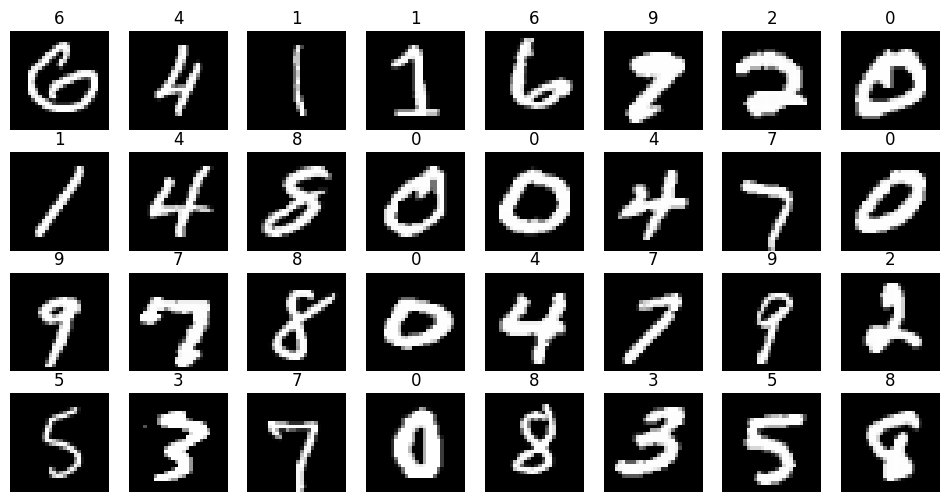

In [5]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
X[0].shape

(1, 28, 28)

In [9]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [13]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.303/0.298	Accuracy: 0.920/0.919

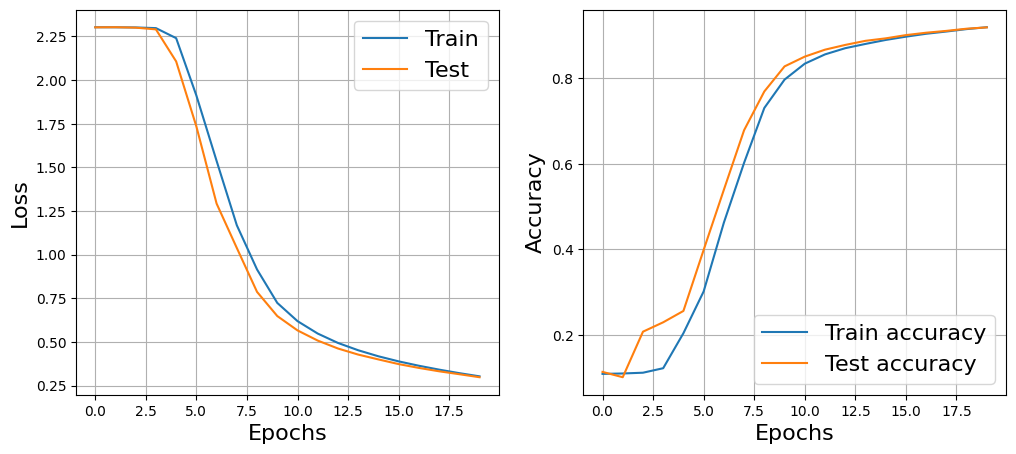

In [9]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [11]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.086	Accuracy: 0.989/0.976

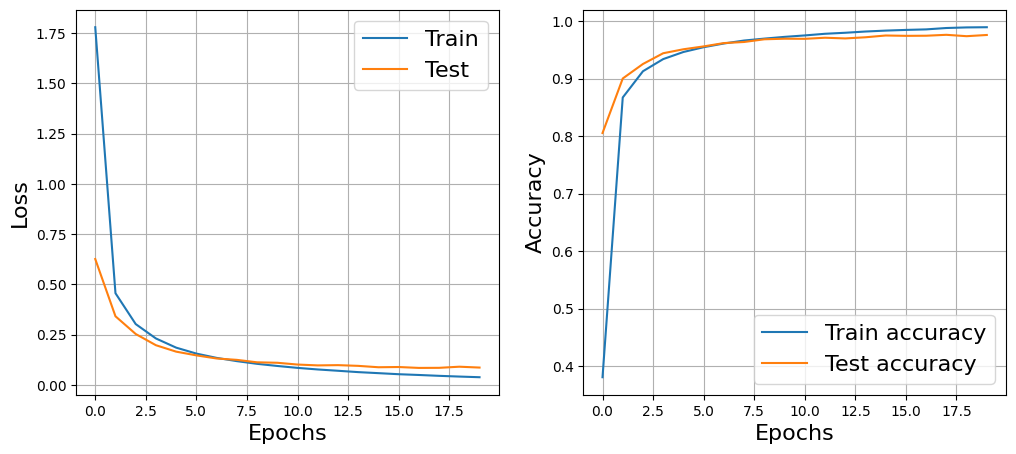

In [11]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.047/0.083	Accuracy: 0.986/0.975

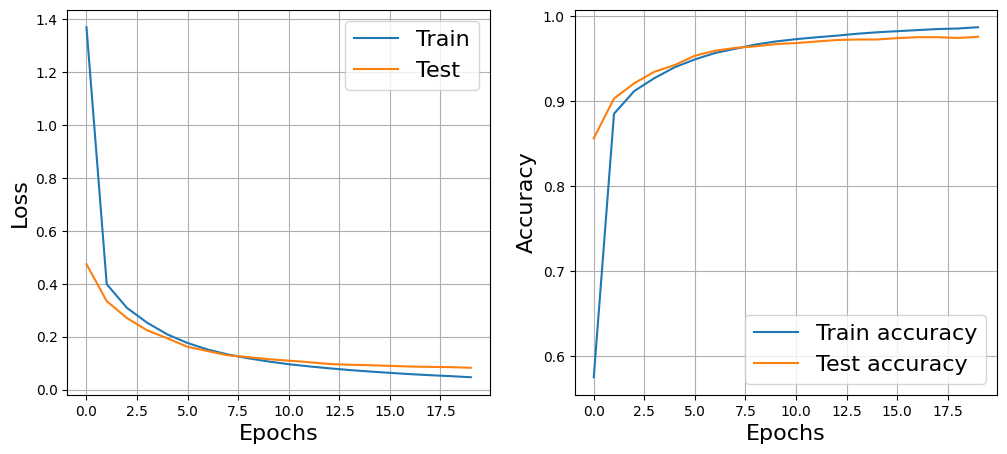

In [12]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение результатов

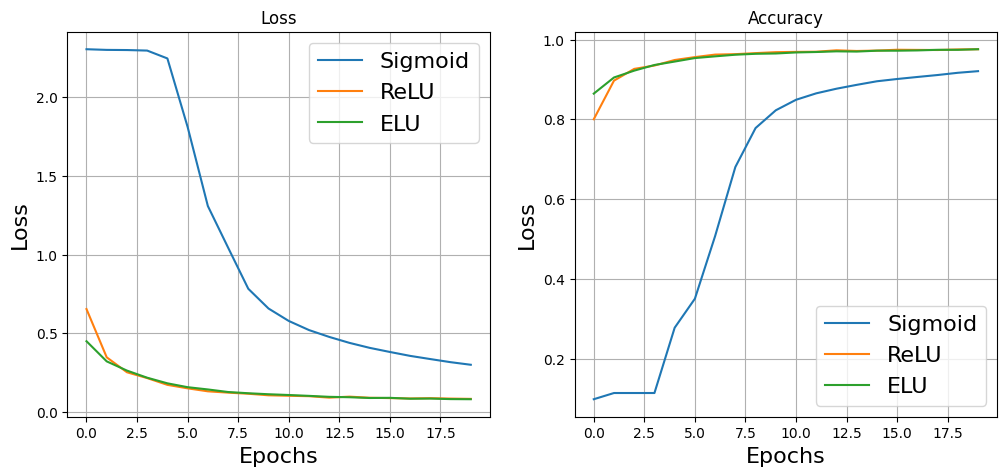

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

# Анализ ошибок

In [18]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

/tmp/ipython-input-1661168083.py:17: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  wrong_X = np.row_stack(wrong_X)
/tmp/ipython-input-1661168083.py:18: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  correct_y = np.row_stack(correct_y)[:, 0]
/tmp/ipython-input-1661168083.py:19: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  predicted_y = np.row_stack(predicted_y)[:, 0]
/tmp/ipython-input-1661168083.py:20: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  logits = np.row_stack(logits)[:, 0]


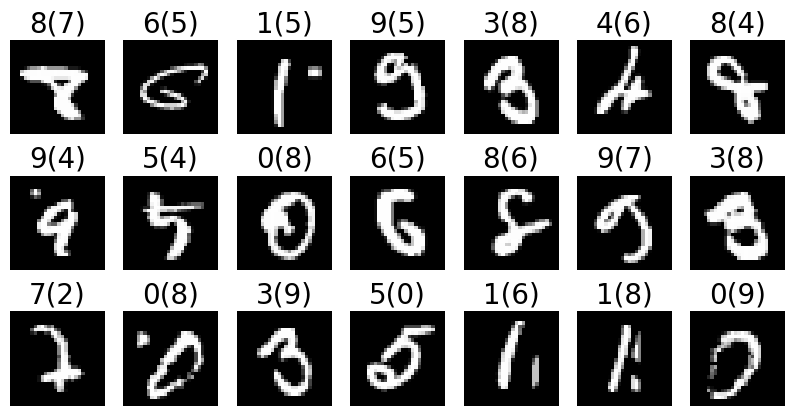

In [19]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [14]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.output = np.tanh(X)
        return self.output

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dtanh_dx = 1 - self.output ** 2
        return dtanh_dx * dLdy

    def step(self, learning_rate):
        pass

## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

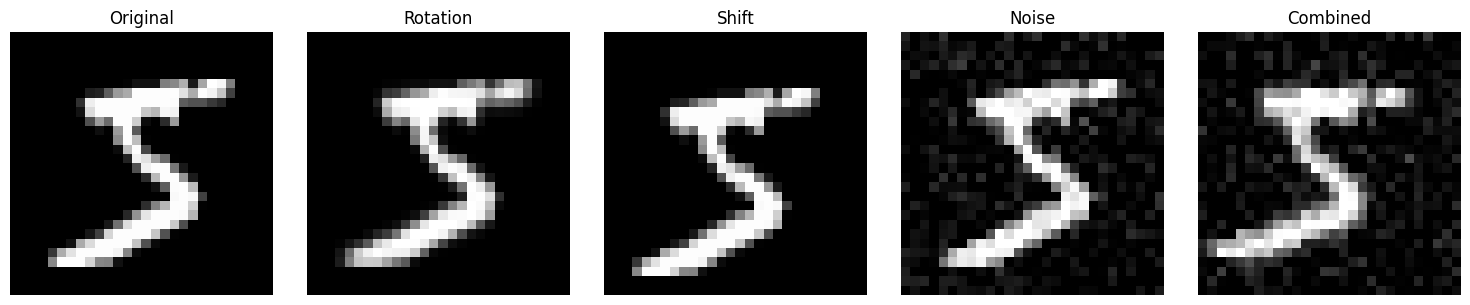

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import copy

class AugmentedDataset(Dataset):
    def __init__(self, dataset, augmentations=None):
        self.dataset = dataset
        self.augmentations = augmentations or []
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Применяем аугментации с вероятностью 50%
        if self.augmentations and np.random.random() > 0.5:
            image_np = image.squeeze().numpy()  # (28, 28)
            
            for augmentation in self.augmentations:
                image_np = augmentation(image_np)
            
            image = torch.from_numpy(image_np).unsqueeze(0).float()
        
        return image, label

# Реализация аугментаций
def small_rotation(image):
    """Небольшие вращения (-15, 15 градусов)"""
    angle = np.random.uniform(-15, 15)
    return rotate(image, angle, mode='edge')

def random_shift(image):
    """Случайные сдвиги"""
    max_shift = 2
    shift_x = np.random.randint(-max_shift, max_shift + 1)
    shift_y = np.random.randint(-max_shift, max_shift + 1)
    
    transform = AffineTransform(translation=(shift_x, shift_y))
    return warp(image, transform, mode='edge')

def add_noise(image):
    """Добавление шума"""
    return random_noise(image, mode='gaussian', var=0.01)

def combined_augmentations(image):
    """Комбинированные аугментации"""
    image = small_rotation(image)
    image = random_shift(image)
    image = add_noise(image)
    return image

# Визуализация аугментаций
def visualize_augmentations():
    """Визуализация эффекта аугментаций"""
    train_dataset = datasets.MNIST('./data', train=True, download=True, 
                                 transform=transforms.ToTensor())
    
    original_image, label = train_dataset[0]
    original_image = original_image.squeeze().numpy()
    
    augmentations = [
        ('Original', lambda x: x),
        ('Rotation', small_rotation),
        ('Shift', random_shift),
        ('Noise', add_noise),
        ('Combined', combined_augmentations)
    ]
    
    plt.figure(figsize=(15, 3))
    for i, (name, aug_func) in enumerate(augmentations):
        plt.subplot(1, 5, i + 1)
        augmented = aug_func(original_image)
        plt.imshow(augmented, cmap='gray')
        plt.title(name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations()

 # Облегченное тестирование, потому что у меня слабый ПК

In [20]:
def small_rotation(image):
    """Небольшие вращения (-15, 15 градусов)"""
    angle = np.random.uniform(-10, 10)
    return rotate(image, angle, mode='edge', preserve_range=True)

def add_noise(image):
    """Добавление шума"""
    noise = np.random.normal(0, 0.05, image.shape)
    return np.clip(image + noise, 0, 255).astype(np.uint8)

class AugmentedDataset(Dataset):
    def __init__(self, dataset, augmentations=None, augmentation_prob=0.5):
        self.dataset = dataset
        self.augmentations = augmentations or []
        self.augmentation_prob = augmentation_prob
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        if self.augmentations and np.random.random() < self.augmentation_prob:
            image_np = image.squeeze().numpy() * 255
            
            for augmentation in self.augmentations:
                image_np = augmentation(image_np)
            
            image_np = image_np.astype(np.float32) / 255.0
            image = torch.from_numpy(image_np).unsqueeze(0).float()
        
        return image, label

In [21]:
def train(network, train_loader, test_loader, epochs=15, learning_rate=0.01, plot=True, verbose=True):
    loss = NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            # Train
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                
                accuracies.append((np.argmax(prediction, 1) == y).mean())
            
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            # Test
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1) == y).mean())
            
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            if verbose and epoch % 3 == 0:
                print(f'Epoch {epoch}: Train Loss: {train_loss_epochs[-1]:.3f}, Test Loss: {test_loss_epochs[-1]:.3f}, '
                      f'Train Acc: {train_accuracy_epochs[-1]:.3f}, Test Acc: {test_accuracy_epochs[-1]:.3f}')
            
            if plot and epoch % 5 == 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
                plt.title('Loss Convergence')
                
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True)
                plt.title('Accuracy Convergence')
                plt.show()
                
    except KeyboardInterrupt:
        pass
    
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_indices = torch.randperm(len(train_dataset))[:4000]  # 4000 примеров
test_indices = torch.randperm(len(test_dataset))[:2000]    # 2000 тестовых

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)

print(f"Размер обучающей выборки: {len(train_subset)}")
print(f"Размер тестовой выборки: {len(test_subset)}")

Размер обучающей выборки: 4000
Размер тестовой выборки: 2000


In [25]:
augmentation_configs = {
    'base': [],
    'rotation': [small_rotation],
    'noise': [add_noise],
    'combined': [small_rotation, add_noise]
}

results = {}

for config_name, augmentations in augmentation_configs.items():
    print(f"\n Обучение с аугментациями: {config_name}")

    augmented_train_dataset = AugmentedDataset(train_subset, augmentations, augmentation_prob=0.6)

    train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

    network = NeuralNetwork([
        Linear(784, 60), 
        Tanh(),
        Linear(60, 10)    
    ])
    
    train_loss, test_loss, train_acc, test_acc = train(
        network, train_loader, test_loader, epochs=12, learning_rate=0.01, plot=False, verbose=True
    )
    
    results[config_name] = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'final_test_acc': test_acc[-1]
    }
    
    print(f" {config_name} завершено: Test Accuracy = {test_acc[-1]:.3f}")


 Обучение с аугментациями: base
Epoch 0: Train Loss: 2.292, Test Loss: 2.280, Train Acc: 0.295, Test Acc: 0.471
Epoch 3: Train Loss: 2.011, Test Loss: 1.877, Train Acc: 0.509, Test Acc: 0.514
Epoch 6: Train Loss: 1.264, Test Loss: 1.158, Train Acc: 0.662, Test Acc: 0.704
Epoch 9: Train Loss: 0.873, Test Loss: 0.816, Train Acc: 0.795, Test Acc: 0.810
 base завершено: Test Accuracy = 0.835

 Обучение с аугментациями: rotation
Epoch 0: Train Loss: 2.295, Test Loss: 2.285, Train Acc: 0.307, Test Acc: 0.480
Epoch 3: Train Loss: 2.067, Test Loss: 1.942, Train Acc: 0.516, Test Acc: 0.512
Epoch 6: Train Loss: 1.342, Test Loss: 1.216, Train Acc: 0.639, Test Acc: 0.680
Epoch 9: Train Loss: 0.930, Test Loss: 0.851, Train Acc: 0.777, Test Acc: 0.803
 rotation завершено: Test Accuracy = 0.835

 Обучение с аугментациями: noise
Epoch 0: Train Loss: 2.295, Test Loss: 2.284, Train Acc: 0.292, Test Acc: 0.433
Epoch 3: Train Loss: 2.039, Test Loss: 1.912, Train Acc: 0.534, Test Acc: 0.524
Epoch 6: Train

# Визуализация сравнения аугментаций

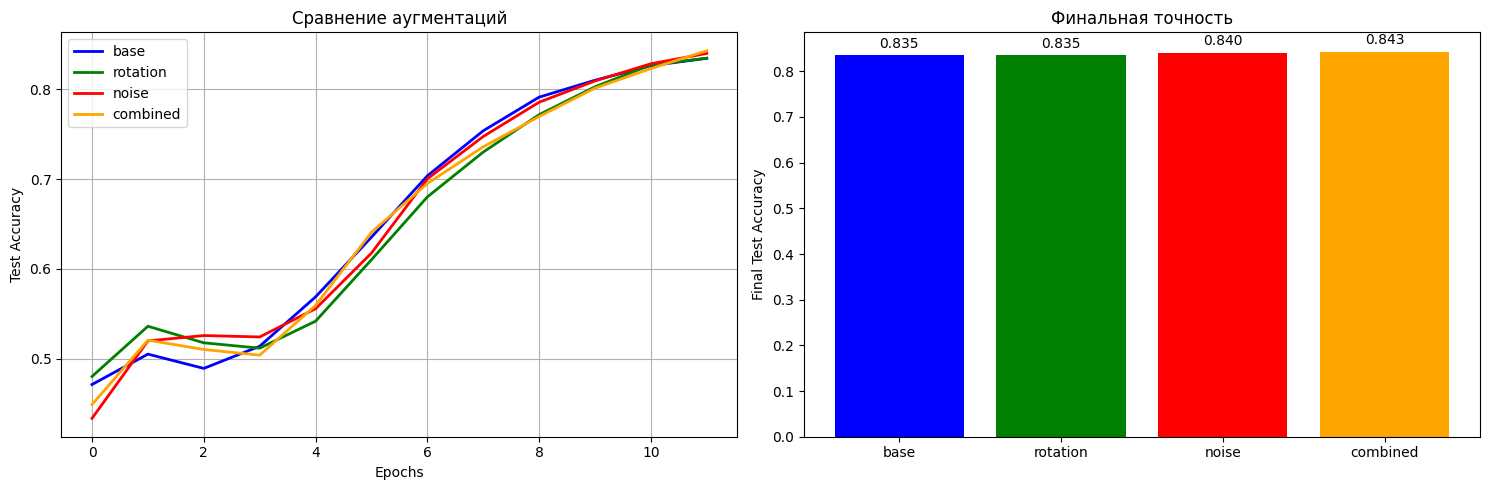

In [26]:
plt.figure(figsize=(15, 5))

colors = {'base': 'blue', 'rotation': 'green', 'noise': 'red', 'combined': 'orange'}

plt.subplot(1, 2, 1)
for name, result in results.items():
    plt.plot(result['test_acc'], label=name, color=colors[name], linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Сравнение аугментаций')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
names = list(results.keys())
accuracies = [results[name]['final_test_acc'] for name in names]

bars = plt.bar(names, accuracies, color=[colors[name] for name in names])
plt.ylabel('Final Test Accuracy')
plt.title('Финальная точность')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Анализ результатов

In [27]:
baseline_acc = results['base']['final_test_acc']
print(f"Базовая точность (без аугментаций): {baseline_acc:.3f}")
print()

print("Прирост точности по сравнению с базовой:")
for name in results.keys():
    if name != 'base':
        improvement = (results[name]['final_test_acc'] - baseline_acc) * 100
        print(f"{name:>10}: {results[name]['final_test_acc']:.3f} ({improvement:+.2f}%)")

best_name = max(results.keys(), key=lambda x: results[x]['final_test_acc'])
best_acc = results[best_name]['final_test_acc']
best_improvement = (best_acc - baseline_acc) * 100

print(f"\n Лучшая аугментация: {best_name}")
print(f"Улучшение: +{best_improvement:.2f}%")


Базовая точность (без аугментаций): 0.835

Прирост точности по сравнению с базовой:
  rotation: 0.835 (+0.00%)
     noise: 0.840 (+0.54%)
  combined: 0.843 (+0.84%)

 Лучшая аугментация: combined
Улучшение: +0.84%
